# Default Credit Classifier

Please read ReadMe.md file to learn more about the pre-requisites to run this Jupyter Notebook file.

## Importing packages

In [75]:
import lightgbm;
import pandas
import matplotlib.pyplot as plt;
from sklearn.model_selection import train_test_split;
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score;

## Data Pre-Processing

To coup up, data pre-processing had steps below:

1. Taking pre-cleaned csv file
The pre-cleaned csv here, means that the header that contains X1 to Y row is cleaned. And change the label column header as "LABEL"

2. Data cleaning
Some exist data is stored and not having value of the one that documented. To prevent any classification errors, we removing it.

3. Perform One-Hot Encoding for the ordinal values

In [76]:
# Loading data from pre-cleaned csv file
dataframe = pandas.read_csv("credit_card_clients.csv");

# Some education data contains 0, 5, and 6. I eliminating 'em.

invalid_education_data = [];
for idx, e in enumerate(dataframe['EDUCATION']):
    if(e > 4 or e < 1):
        invalid_education_data.append(idx);

# Some marriage data contains 0. I eliminating 'em.

invalid_marriage_data = [];
for idx, e in enumerate(dataframe['MARRIAGE']):
    if(e == 0):
        invalid_marriage_data.append(idx);

final_invalid_data_index = [];
for e in [invalid_marriage_data, invalid_education_data]:
    for f in e:
        
        # Check the index. If it throw exception, append the number. 
        try:
            final_invalid_data_index.index(f);
            continue;
        except:
            final_invalid_data_index.append(f);

dataframe = dataframe.drop(final_invalid_data_index);

# Make one hot encoding for Sex, Educuation, and Marriage since the data is an ordinal data
hot_encoded_sex = pandas.get_dummies(dataframe['SEX'], prefix = "sex");
hot_encoded_education = pandas.get_dummies(dataframe['EDUCATION'], prefix = "education");
hot_encoded_marital_status = pandas.get_dummies(dataframe['MARRIAGE'], prefix = "marital_status");

# Merge the hot_encoded with the main dataframe
for i in [hot_encoded_sex, hot_encoded_education,hot_encoded_marital_status]:
    dataframe = pandas.concat([dataframe, i], axis = 1);



print("Data after cleaning: ", dataframe.shape);
print(dataframe.columns.tolist());

Data after cleaning:  (29601, 34)
['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'LABEL', 'sex_1', 'sex_2', 'education_1', 'education_2', 'education_3', 'education_4', 'marital_status_1', 'marital_status_2', 'marital_status_3']


## Split train-test data
In this part, we split the data by 9:1 percentile. Also defining which one is label and features.

In [77]:
# Define label data
label = dataframe['LABEL'];

# Drop ID, SEX, EDUCATION, MARRIAGE, and LABEL from dataframe for features
features = dataframe.drop(columns=["ID", "SEX", "EDUCATION", "MARRIAGE", "LABEL"]);

# Split the data into training and testing sets
feature_train, feature_test, label_train, label_test = train_test_split(features, label, test_size=0.1, random_state=0);

train_data = lightgbm.Dataset(feature_train, label = label_train);
test_data = lightgbm.Dataset(feature_test, label = label_test, reference = train_data);

# Model fitting meta data
Here lies the meta data for training the model

In [78]:
# Set up the configuration for LightGBM
config = {
    "objective": "binary",
    "metric": {"binary_logloss"},
    "is_training_metric": True,
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 1e-3,
    "feature_fraction": 0.9,
    "verbosity": 1,
    "device_type": "cpu",
};

epochs = 500;
evaluation_result = {};

# Fitting model

In [79]:
# Train the LightGBM model
model = lightgbm.train(params=config, train_set=train_data, num_boost_round=epochs, valid_sets=[test_data], callbacks=[lightgbm.record_evaluation(evaluation_result), lightgbm.log_evaluation()]);

[LightGBM] [Info] Number of positive: 6002, number of negative: 20638
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3272
[LightGBM] [Info] Number of data points in the train set: 26640, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.225300 -> initscore=-1.235041
[LightGBM] [Info] Start training from score -1.235041
[1]	valid_0's binary_logloss: 0.50659
[2]	valid_0's binary_logloss: 0.506389
[3]	valid_0's binary_logloss: 0.506191
[4]	valid_0's binary_logloss: 0.505994
[5]	valid_0's binary_logloss: 0.505793
[6]	valid_0's binary_logloss: 0.505593
[7]	valid_0's binary_logloss: 0.505393
[8]	valid_0's binary_logloss: 0.505196
[9]	valid_0's binary_logloss: 0.505006
[10]	valid_0's binary_logloss: 0.504809
[11]	valid_0's binary_logloss: 0.504612
[12]	valid_0's binary_logloss: 0.504476
[13]	valid_0's binary_logloss: 0.5043

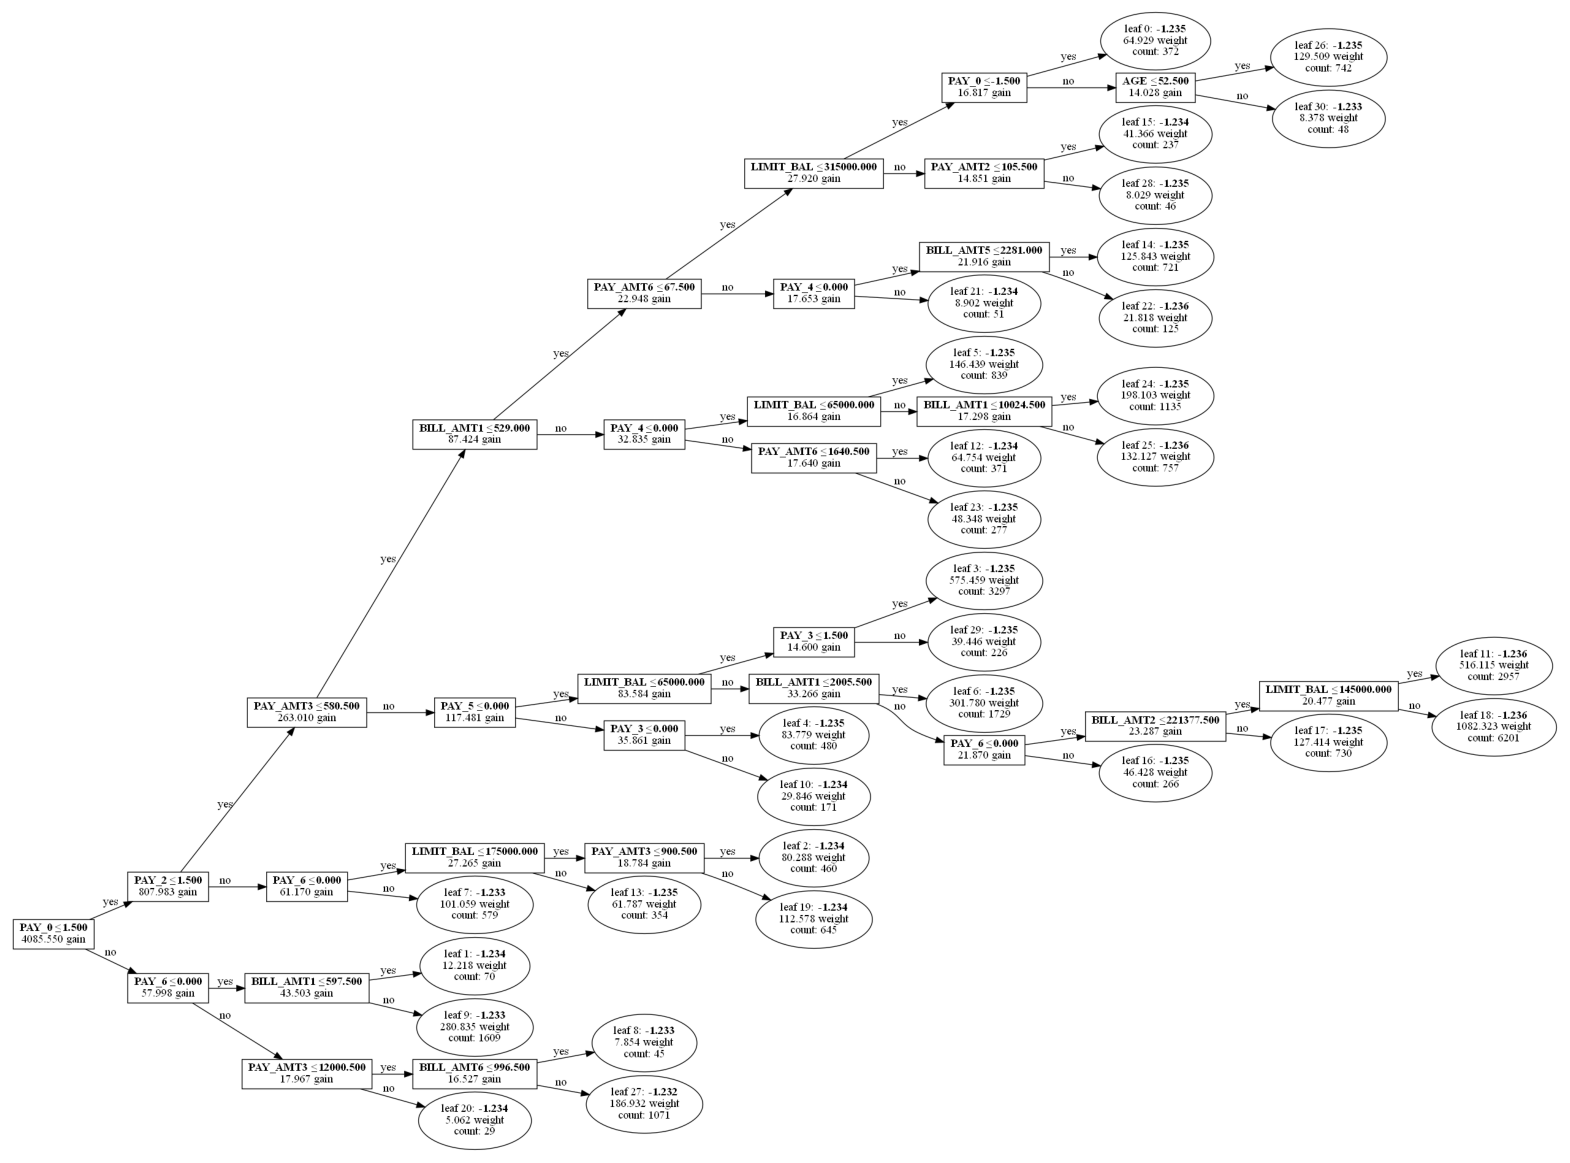

In [80]:

# Visualize the first tree
lightgbm.plot_tree(model, tree_index=0, figsize=(20, 15), show_info=['split_gain', 'leaf_weight', 'leaf_count']);
plt.show();

# Model evaluation 1: Feature Importance 

<Figure size 1000x600 with 0 Axes>

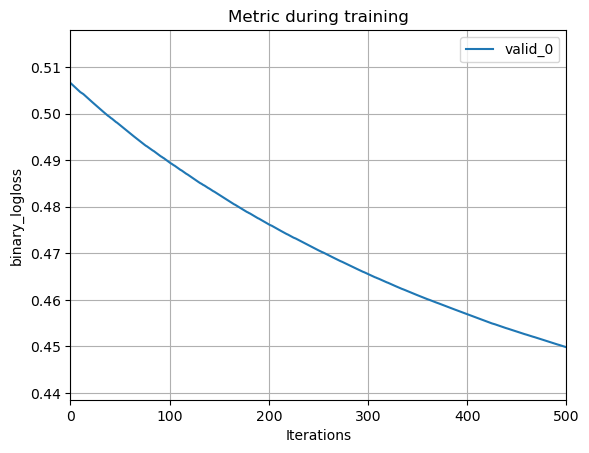

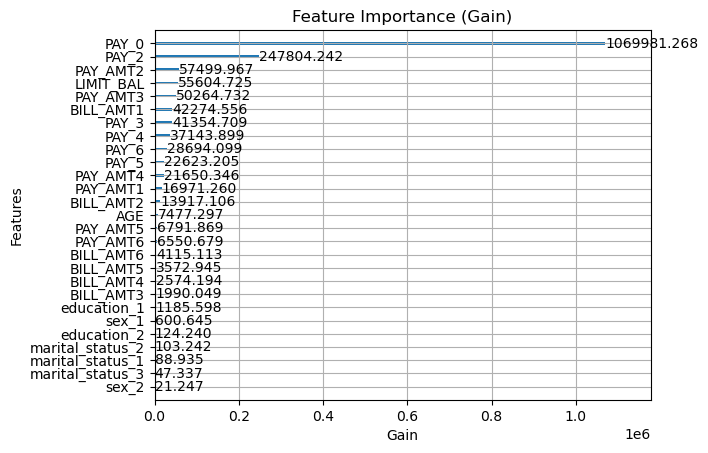

In [81]:
# Plot model evaluation metrics
plt.figure(figsize=(10, 6));

lightgbm.plot_metric(evaluation_result);
lightgbm.plot_importance(model, importance_type='gain', title='Feature Importance (Gain)', xlabel='Gain');
plt.show();

# Model evaluation 2: Prediction accuracy

In [82]:
# Make predictions on the test set
prediction = model.predict(feature_test, num_iteration=model.best_iteration);
binarized_prediction_result = [1 if pred > 0.5 else 0 for pred in prediction];

print(f"Best iteration: {model.best_iteration}")

# Evaluate the model
accuracy = accuracy_score(label_test, binarized_prediction_result);
print(f"Accuracy: {accuracy}");

# Calculate mean squared error
loss = log_loss(label_test, prediction);
print(f"Log Loss: {loss}");

auc_roc = roc_auc_score(label_test, binarized_prediction_result);
print(f"AUC-ROC: {auc_roc}");

Best iteration: 0
Accuracy: 0.7963525835866262
Log Loss: 0.44990599154802735
AUC-ROC: 0.5


: 